In [1]:
# -------------------------------------------------------- 
 # ROSITA
 # Licensed under The Apache License 2.0 [see LICENSE for details] 
 # Written by Yuhao Cui and Tong-An Luo
 # -------------------------------------------------------- 

import os
os.chdir('../')
os.getcwd()
# make sure the current work dir is the root 'rosita'.

'/home/luota/milvlg/vlp/rosita_gh/rosita'

In [2]:
import torch, cv2, yaml, random, copy
import torch.nn.functional as F
import numpy as np
from demo_maskatt import DemoCfg, Net
from rosita.data.load_data_mask_att import DataSet
import matplotlib.pyplot as plt

%matplotlib inline

# set display defaults
plt.rcParams['figure.figsize'] = (9, 12)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [3]:
config_file = 'configs/demo-maskatt.yaml'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
class Arg():
    def __init__(self):
        self.NODE_SIZE = 1
args = Arg()
__C = DemoCfg(world_size=1, args=args)
__C.proc(resume=False)
# print(__C)

In [4]:
with open(config_file, 'r') as f:
        yaml_dict = yaml.load(f, Loader=yaml.FullLoader)
__C.add_args(yaml_dict)

In [5]:
torch.manual_seed(__C.SEED)
torch.cuda.manual_seed(__C.SEED)
torch.cuda.manual_seed_all(__C.SEED)
np.random.seed(__C.SEED)
random.seed(__C.SEED)
torch.backends.cudnn.benchmark = True
torch.set_printoptions(profile="full")
np.set_printoptions(threshold=1e9)

In [6]:
dataset = DataSet(__C, __C.RUN_MODE, text_segment=None, spacy_tool=None)

In [7]:
# Load Checkpoint
ckpt_path = __C.CKPT_FILE
ckpt = torch.load(ckpt_path)
init_map = {'vocab_size': dataset.vocab_size}
net = Net(__C, init_map)

net.to('cuda:0')

for weight_key in __C.CKPT_SAVE_MAP:
    if weight_key not in ['net_optim', 'epoch']:
        getattr(net, weight_key).load_state_dict(ckpt[__C.CKPT_SAVE_MAP[weight_key]])

net.eval()

Net(
  (text_embeddings): TextEmbeddings(
    (word_embeddings): Embedding(30522, 768)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (layer_norm): LayerNorm()
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (visual_embeddings): VisualEmbeddings(
    (dense_imgfeat): Linear(in_features=2048, out_features=768, bias=True)
    (dense_bboxfeat): Linear(in_features=5, out_features=768, bias=True)
    (layer_norm): LayerNorm()
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (backbone): Backbone(
    (layers): ModuleList(
      (0): SelfAtt(
        (mhatt): MHAtt(
          (dense_v): Linear(in_features=768, out_features=768, bias=True)
          (dense_k): Linear(in_features=768, out_features=768, bias=True)
          (dense_q): Linear(in_features=768, out_features=768, bias=True)
          (dense_merge): Linear(in_features=768, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ffn): Fe

In [8]:
text_id = 480   # the sample on the paper
text = dataset.clean_text(dataset.data_aggr[text_id]['text'])
print(text)

an older woman standing next to two children


In [9]:
mask_side = 'text'
mask_id = [2, 7]

image_path: demo/images/COCO_val2014_000000124629.jpg


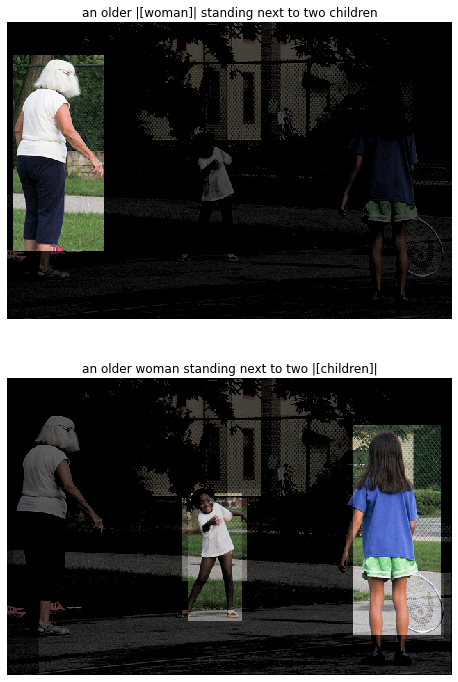

In [10]:
with torch.no_grad():
    text_input_ids, text_mask, text_mlm_label_ids, \
    imgfeat_input, imgfeat_mask, imgfeat_bbox, \
    mask_id_list, text_len, img_filename, boxes = dataset.get_item(text_id, mask_side, mask_id)

    text_input_ids_batch = text_input_ids.to('cuda:0').unsqueeze(0)
    text_mask_batch = text_mask.to('cuda:0').unsqueeze(0)
    imgfeat_input_batch = imgfeat_input.to('cuda:0').unsqueeze(0)
    imgfeat_mask_batch = imgfeat_mask.to('cuda:0').unsqueeze(0)
    imgfeat_bbox_batch = imgfeat_bbox.to('cuda:0').unsqueeze(0)

    net_input = (text_input_ids_batch, text_mask_batch, imgfeat_input_batch, imgfeat_mask_batch, imgfeat_bbox_batch)
    net_output = net(net_input)

    scores_out_list = net_output

    text_label = [dataset.tokenizer.ids_to_tokens[t.item()] for t in text_mlm_label_ids][1: 1 + text_len]
    img_root_path = 'demo/images/'
    img_path = img_root_path + img_filename
    print(f'image_path: {img_path}')

    def att_text(text_lbl, msk_id):
        if msk_id != -1:
            text_lbl[msk_id] = '|[{}]|'.format(text_lbl[msk_id])
        text_att = ''
        for i in range(len(text_lbl)):
            if i == 0:
                text_att += text_lbl[i]
            elif text_lbl[i].startswith('#'):
                text_att += text_lbl[i].replace('#', '')
            else:
                text_att += ' ' + text_lbl[i]
        return text_att

    if mask_side == 'text':
        weights_list = []
        for idx in mask_id_list:
            scores = copy.deepcopy(scores_out_list[-1][0, :, idx + 1, -36:].sum(-2))
            weights = F.softmax(scores, dim=-1).numpy()
            weights_list.append(weights)
        if len(mask_id_list) == 0:
            scores = copy.deepcopy(scores_out_list[-1][0, :, :-36, -36:].sum(-3).sum(-2))
            weights = F.softmax(scores, dim=-1).numpy()
            weights_list.append(weights)

        for weight_id, weights in enumerate(weights_list):
            if len(mask_id_list):
                text_att = att_text(copy.deepcopy(text_label), mask_id_list[weight_id])
            else:
                text_att = att_text(copy.deepcopy(text_label), -1)
            # print(text_att)
            img_att = cv2.imread(img_path)
            Vv = 180.
            max_imgfeat = 36
            mask = np.zeros_like(img_att[:, :, 2], dtype=np.float32)
            for ix, box in enumerate(boxes):
                if ix == max_imgfeat:
                    break
                x1 = int(box[0])
                y1 = int(box[1])
                x2 = int(box[2])
                y2 = int(box[3])
                mask[y1:y2, x1:x2] = mask[y1:y2, x1:x2] + weights[ix]
            mask = (mask - np.min(mask)) / (np.max(mask) - np.min(mask))
            mask = np.power(mask, 0.3)
            picHSV = cv2.cvtColor(img_att, cv2.COLOR_BGR2HSV).astype(np.float32)
            picHSV[:, :, 2] = picHSV[:, :, 2] - Vv
            picHSV[:, :, 2] = picHSV[:, :, 2] + mask * Vv
            picHSV[:, :, 2][picHSV[:, :, 2] < 0] = 0
            picHSV[:, :, 2][picHSV[:, :, 2] > 250] = 250
            img_att = cv2.cvtColor(picHSV.astype(np.uint8), cv2.COLOR_HSV2RGB)
            plt.subplot(len(weights_list), 1, weight_id+1)
            plt.title(text_att)
            plt.imshow(img_att)
            plt.axis('off')
        plt.show()